# OFDM-Synchronisation nach Schmidl u. Cox

Beschrieben in: T. Schmidl u. D. Cox, *Robust Frequency and Timing Synchronization for OFDM*, IEEE Transactions on Communications, December 1997

Modell: Präambelsymbole generieren -> IFFT -> CP einfügen -> Kanal -> Synchronisation ( -> Entzerrung)

In [2]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})


L = 1024    # Anzahl Punkte in der DFT
K = 3*L//4    # Anzahl belegter Unterträger, muss gerade sein
n_CP = L//4  # Länge des Cyclic Prefix
threshold = 0.8  # Threshold for presence detection

t_off = 1000  # Zeitoffset
f_off = 11.3  # Frequenzoffset in Vielfachen des Unterträgerabstands
h_awgn = [1.,]   # Kanalimpulsantwort für AWGN
h_multipath = np.linspace(1, 0, n_CP//2) * np.exp(1j*np.random.uniform(-np.pi, np.pi, n_CP//2))  # Mehrwegekanal
h_multipath /= np.sqrt(np.mean(np.abs(h_multipath)**2))  # normieren
h = h_awgn  # Kanal wählen
SNR = 10     # SNR in dB

## Präambel generieren (BPSK)

In [3]:
pn1 = np.random.choice([-np.sqrt(2), np.sqrt(2)], K//2) # erste PN Sequenz
pn2 = np.random.choice([-1, 1], K)  # zweite PN Sequenz

## IFFT

In [4]:
c1 = np.zeros((L,))
c1[L//2-K//2:L//2+K//2:2] = pn1  # nur gerade Unterträger werden belegt
s1 = np.fft.ifft(np.fft.fftshift(c1))

c2 = np.zeros((L,))
c2[L//2-K//2:L//2+K//2] = pn2  # alle Unterträger werden belegt
s2 = np.fft.ifft(np.fft.fftshift(c2))

v = np.sqrt(2)*pn2[::2]/pn1

## Cyclic Prefix einfügen

In [5]:
s = np.concatenate((s1[-n_CP:], s1, s2[-n_CP:], s2))

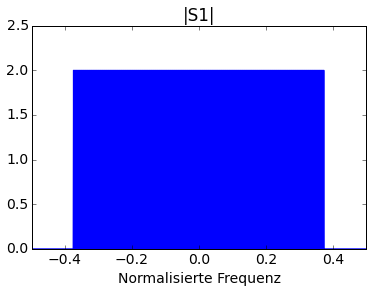

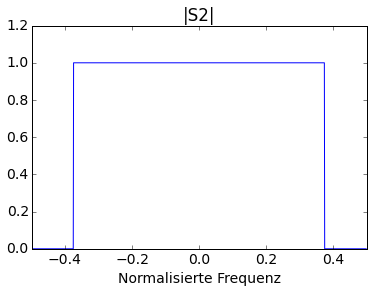

In [6]:
f = np.linspace(-0.5, 0.5, L, endpoint=False)
S1 = np.abs(np.fft.fftshift(np.fft.fft(s[:L])))**2
plt.plot(f, np.abs(S1))
plt.title("|S1|"); plt.xlabel("Normalisierte Frequenz"); plt.xlim([-0.5, 0.5])
plt.show()

S2 = np.abs(np.fft.fftshift(np.fft.fft(s[L+2*n_CP:])))**2
plt.plot(f, np.abs(S2))
plt.title("|S2|"); plt.xlabel("Normalisierte Frequenz"); plt.xlim([-0.5, 0.5])
plt.show()

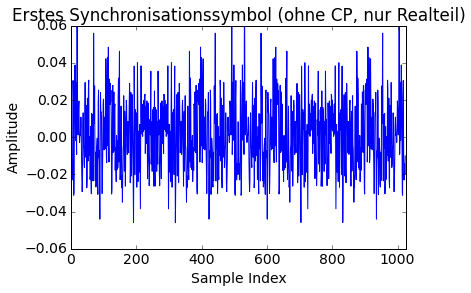

In [7]:
plt.plot(np.real(s[n_CP:n_CP+L]))
plt.title("Erstes Synchronisationssymbol (ohne CP, nur Realteil)"); 
plt.ylabel("Amplitude"); plt.xlabel("Sample Index");plt.xlim([0, L])
plt.show()

## Kanal

In [8]:
# Faltung mit Kanalimpulsantwort
r = np.convolve(s, h, mode="full")
filter_delay = (len(h)-1)//2
r = r[filter_delay:]  # Einschwingzeit entfernen

# Frequenzoffset
r *= np.exp(1j*2*np.pi*f_off*np.arange(len(r))/L)

# Zeitoffset
r = np.concatenate((np.zeros((t_off,), dtype=complex), r))

# AWGN
P_s = np.mean(np.abs(r[t_off:])**2)  # mittlere Signalleistung
sigma = 10**(-SNR/20) * np.sqrt(P_s)
n = sigma * (np.sqrt(1/2) * np.random.randn(len(r)) + 1j * np.sqrt(1/2) * np.random.randn(len(r)))
r += n

## Synchronisation

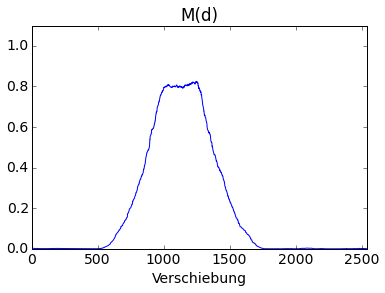

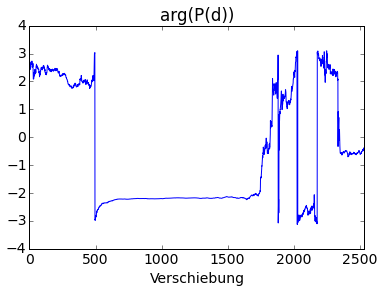

In [9]:
# Fixed Lag Correlation
Pd = np.asarray([np.sum(np.conj(r[i:i+L//2])*r[i+L//2:i+L]) for i in range(len(r)-L)])
Rd = np.asarray([np.sum(np.abs(r[i+L//2:i+L])**2) for i in range(len(r) - L)])
M = np.abs(Pd/Rd)**2

plt.plot(np.abs(M)); plt.title("M(d)"); plt.xlabel("Verschiebung"); plt.xlim([0, len(M)]); plt.ylim([0,1.1]); plt.show()
plt.plot(np.angle(Pd)); plt.title("arg(P(d))"); plt.xlabel("Verschiebung"); plt.xlim([0, len(M)]); plt.show()

In [10]:
# Signaldetektion
signal_detected = any(M > threshold)
print("Präambel erkannt!" if signal_detected else "Keine Präambel erkannt.")

Präambel erkannt!


In [11]:
# Schätzung Zeitoffset
if signal_detected:
    # t_est = np.argmax(M)  # keine gute Idee wegen des Plateaus
    M_over_threshold = [idx for idx in range(len(M)) if M[idx] > threshold]
    t_est = M_over_threshold[0] + 3*n_CP//4  # "ad-hoc" Ansatz
    t_valid = [t_off+len(h), t_off+n_CP]  # Im realen System ist t_off natürlich unbekannt!
    t_est_valid = t_valid[0] <= t_est < t_valid[1]
    print("Geschätzter Zeitoffset: " + str(t_est) + " Samples. Gültiger Bereich: " + str(t_valid) + ". Schätzung im gültigen Bereich: " + str(t_est_valid))

Geschätzter Zeitoffset: 1208 Samples. Gültiger Bereich: [1001, 1256]. Schätzung im gültigen Bereich: True


In [12]:
# Fractional Frequency Offset Schätzung und Korrektur
if signal_detected:
    f_F = np.angle(Pd[t_est])/np.pi
    r *= np.exp(-1j*2*np.pi*f_F*np.arange(len(r))/L)
    print("Geschätzter Fractional Frequency Offset: " + str(f_F))

Geschätzter Fractional Frequency Offset: -0.694176715458


Geschätzter Integer Frequency Offset: 12
Geschätzter Frequenzoffset (integer + fractional): 11.3058232845


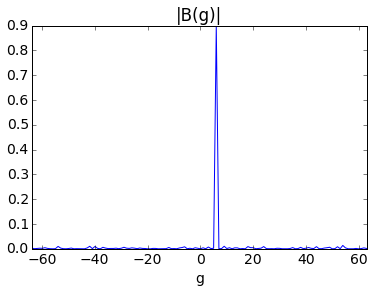

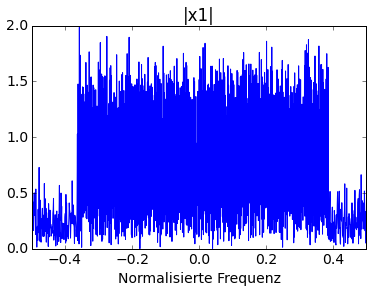

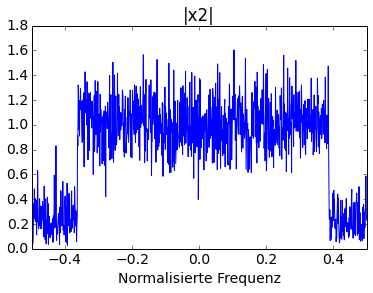

In [13]:
# Integer Frequency Offset Schätzung und Korrektur
if signal_detected:
    # Präambelsymbole extrahieren, Cyclic Prefix wegschneiden
    s1_est = r[t_est:t_est+L]  
    s2_est = r[t_est+L+n_CP:t_est+2*L+n_CP]
    
    # in den Frequenzbereich transformieren, in intuitive Lage bringen
    x1 = np.fft.fftshift(np.fft.fft(s1_est))  
    x2 = np.fft.fftshift(np.fft.fft(s2_est)) 
    
    # B(g) berechnen
    k = np.concatenate((np.arange(-K//2, 0, 2), np.arange(2, K//2, 2))) + L//2
    v_nodc = np.delete(v, K//2//2)
    E_x2 = np.sum(np.abs(x2[k])**2)
    possible_offsets = range(-(L-K)//2//2, (L-K)//2//2, 1) 
    B = np.zeros((len(possible_offsets,)), dtype=np.complex)
    for i, g in enumerate(possible_offsets):
        B[i] = (np.abs(np.sum(np.conj(x1[k+2*g])*np.conj(v_nodc)*x2[k+2*g]))**2)/(2*E_x2**2)

    # Integer Frequency Offset berechnen
    g_est = np.argmax(B)
    f_I = 2*g_est - (L-K)//2
    print("Geschätzter Integer Frequency Offset: " + str(f_I))
    
    print("Geschätzter Frequenzoffset (integer + fractional): " + str(f_I + f_F))
    plt.plot(possible_offsets, np.abs(B)); plt.title("|B(g)|"); plt.xlabel("g"); plt.xlim([possible_offsets[0], possible_offsets[-1]]); plt.show()    
    plt.plot(f, np.abs(x1)); plt.title("|x1|"); plt.xlabel("Normalisierte Frequenz"); plt.xlim([f[0], f[-1]]); plt.show()
    plt.plot(f, np.abs(x2)); plt.title("|x2|"); plt.xlabel("Normalisierte Frequenz"); plt.xlim([f[0], f[-1]]); plt.show()

## Entzerrung
Anmerkung: Entzerrung ist nicht mehr Teil des beschriebenen Verfahrens von Schmidl und Cox, es kann jedoch auch dafür verwendet werden.

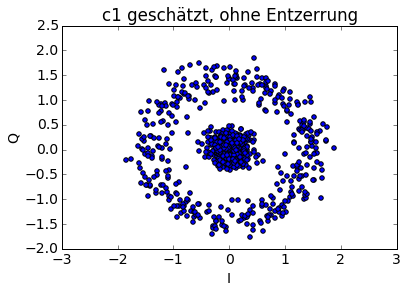

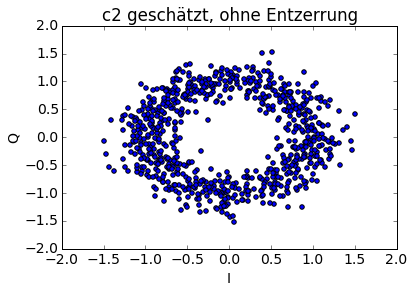

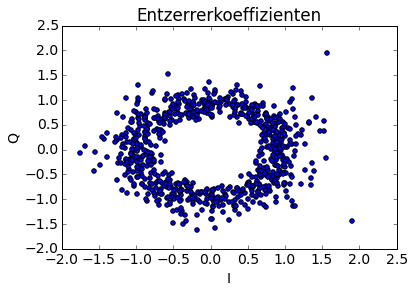

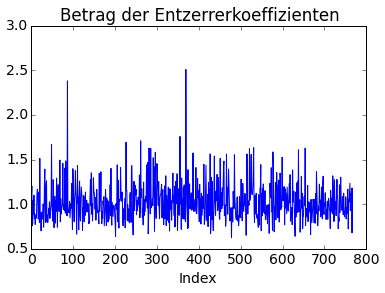

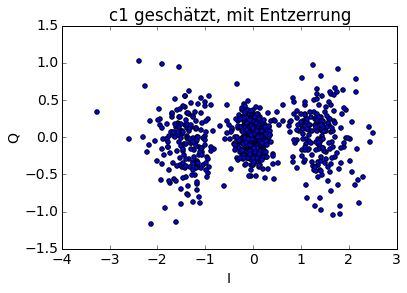

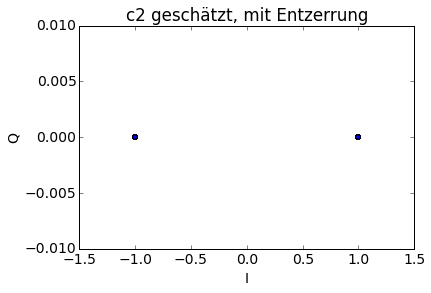

In [14]:
if signal_detected:
    band_start_idx = L//2 - K//2 + f_I
    band_stop_idx = band_start_idx + K   
    f_I_valid = band_start_idx >= 0 and band_stop_idx < L
    if(not f_I_valid):
        print("Ungültiger Frequenzoffset!")
    else:
        c1_est = x1[band_start_idx : band_stop_idx]
        c2_est = x2[band_start_idx : band_stop_idx]
        plt.scatter(c1_est.real, c1_est.imag); plt.title("c1 geschätzt, ohne Entzerrung"); plt.xlabel("I"); plt.ylabel("Q"); plt.show()
        plt.scatter(c2_est.real, c2_est.imag); plt.title("c2 geschätzt, ohne Entzerrung"); plt.xlabel("I"); plt.ylabel("Q"); plt.show()

        ZF_eq = 1 / (c2_est / pn2)  # berechne Zero-Forcing Entzerrerkoeffizienten um den verbleibenden Phasenoffset zu korrigieren
        c1_est_eq = c1_est * ZF_eq
        c2_est_eq = c2_est * ZF_eq
        plt.scatter(ZF_eq.real, ZF_eq.imag); plt.title("Entzerrerkoeffizienten")
        plt.xlabel("I"); plt.ylabel("Q"); plt.show()
        plt.plot(np.abs(ZF_eq)); plt.title("Betrag der Entzerrerkoeffizienten")
        plt.xlabel("Index"); plt.show()
        plt.scatter(c1_est_eq.real, c1_est_eq.imag); plt.title("c1 geschätzt, mit Entzerrung")
        plt.xlabel("I"); plt.ylabel("Q"); plt.show()
        plt.scatter(c2_est_eq.real, c2_est_eq.imag); plt.title("c2 geschätzt, mit Entzerrung")
        plt.xlabel("I"); plt.ylabel("Q"); plt.show()    